In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor


Goal: predict Ames house SalePrice with three models using at least
one ordinal variable
one nominal (categorical) variable
one engineered feature
≥ 5 total predictors

Aim: to predict Ames house SalePrice with three models using at least one ordinal variable one nominal (categorical) variable one engineered feature ≥ 5 total predictors

The Ames Housing dataset is a collection of 2,930 residential sales in Ames, Iowa. Our aim is to build three regression models that predict SalePrice - a linear, ridge, and random forest regression model. We will investigate the data; create a TotalSF variable; encode the categorical variables; split it into training and test sets (80/20; seed = 42); and evaluate the model using MAE, RMSE, and R² on the test set and comparing it to a mean-price benchmark using all training dataset observations.

We chose the Ames Housing dataset for our analysis because it is modern, well described, and a legitimate ethical substitute for the now retired Boston Housing dataset. The Ames Housing dataset has nearly ten times the observations (2,930 vs. 506 observations), more features (79 vs. 14 features), and better schema (a legal artifact of poor project management, scikit-learn retired!) and avoids the issues of fairness and licensing that led scikit-learn to retire Boston. Ames is therefore the teaching benchmark for current iterations of regression workflows.

In [31]:
df = pd.read_csv('AmesHousing.csv')  # load the Ames Housing CSV
print(df.shape)                      # print (rows, columns)
df.head()                            # preview first five rows


(2930, 82)


Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       5    2010       WD           Normal     215000  
1        0       6    2010       WD           Normal     105000  
2    12500       6    2010       WD           Normal     172000  
3        0       4    2010       WD           Normal     244000  
4        0       3    2010       WD           Normal     189900  

[5 rows x 82 columns]

In [7]:
df.describe(include='all').T.head(15) #Look at columns

count unique     top  freq              mean              std  \
Order         2930.0    NaN     NaN   NaN            1465.5        845.96247   
PID           2930.0    NaN     NaN   NaN  714464496.988737  188730844.64939   
MS SubClass   2930.0    NaN     NaN   NaN         57.387372        42.638025   
MS Zoning       2930      7      RL  2273               NaN              NaN   
Lot Frontage  2440.0    NaN     NaN   NaN          69.22459        23.365335   
Lot Area      2930.0    NaN     NaN   NaN      10147.921843      7880.017759   
Street          2930      2    Pave  2918               NaN              NaN   
Alley            198      2    Grvl   120               NaN              NaN   
Lot Shape       2930      4     Reg  1859               NaN              NaN   
Land Contour    2930      4     Lvl  2633               NaN              NaN   
Utilities       2930      3  AllPub  2927               NaN              NaN   
Lot Config      2930      5  Inside  2140               NaN              NaN   
Land Slope      2930      3     Gtl  2789               NaN              NaN   
Neighborhood    2930     28   NAmes   443               NaN              NaN   
Condition 1     2930      9    Norm  2522               NaN              NaN   

                      min          25%          50%          75%           max  
Order                 1.0       733.25       1465.5      2197.75        2930.0  
PID           526301100.0  528477022.5  535453620.0  907181097.5  1007100110.0  
MS SubClass          20.0         20.0         50.0         70.0         190.0  
MS Zoning             NaN          NaN          NaN          NaN           NaN  
Lot Frontage         21.0         58.0         68.0         80.0         313.0  
Lot Area           1300.0      7440.25       9436.5     11555.25      215245.0  
Street                NaN          NaN          NaN          NaN           NaN  
Alley                 NaN          NaN          NaN          NaN           NaN  
Lot Shape             NaN          NaN          NaN          NaN           NaN  
Land Contour          NaN          NaN          NaN          NaN           NaN  
Utilities             NaN          NaN          NaN          NaN           NaN  
Lot Config            NaN          NaN          NaN          NaN           NaN  
Land Slope            NaN          NaN          NaN          NaN           NaN  
Neighborhood          NaN          NaN          NaN          NaN           NaN  
Condition 1           NaN          NaN          NaN          NaN           NaN

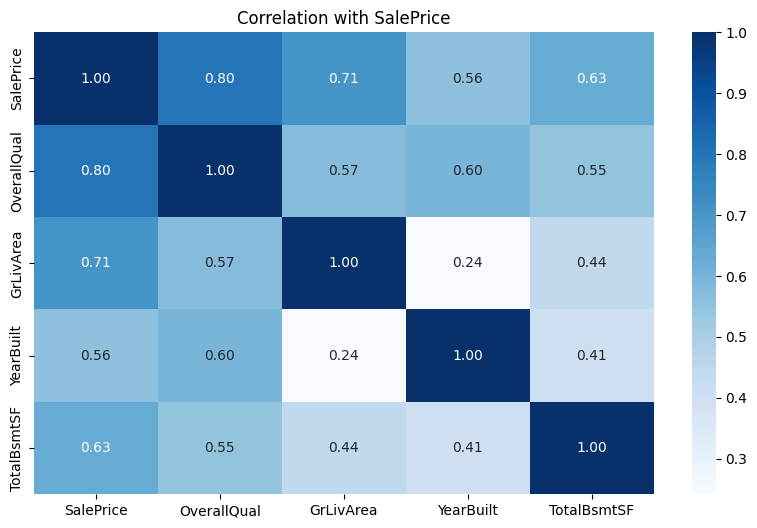

In [28]:
df.columns = df.columns.str.strip().str.replace(' ', '')        # remove spaces in column names
plt.figure(figsize=(10,6))                                      # canvas size
sns.heatmap(                                                    # draw correlation matrix
    df[['SalePrice','OverallQual','GrLivArea','YearBuilt','TotalBsmtSF']].corr(),
    annot=True, fmt='.2f', cmap='Blues')                        # show values, blue palette
plt.title('Correlation with SalePrice')                         # plot title
plt.show()                                                      # display plot


**What we see:**  
* OverallQual (≈ 0.8) and GrLivArea (≈ 0.7) show the strongest positive connections to SalePrice.  
* YearBuilt and TotalBsmtSF are moderately linked, suggesting that newer homes and finished basements increase value.  
* No strong negative links are found in this subset.

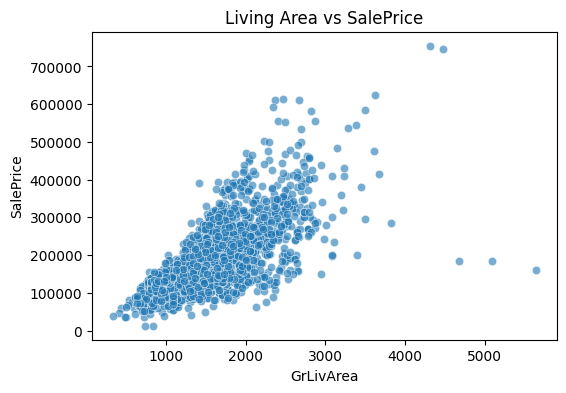

In [13]:
plt.figure(figsize=(6,4))                                    # set plot size (width=6, height=4 inches)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df, alpha=0.6)  # scatter: living area vs. price
plt.title('Living Area vs SalePrice')                        # add chart title
plt.show()                                                   # display plot


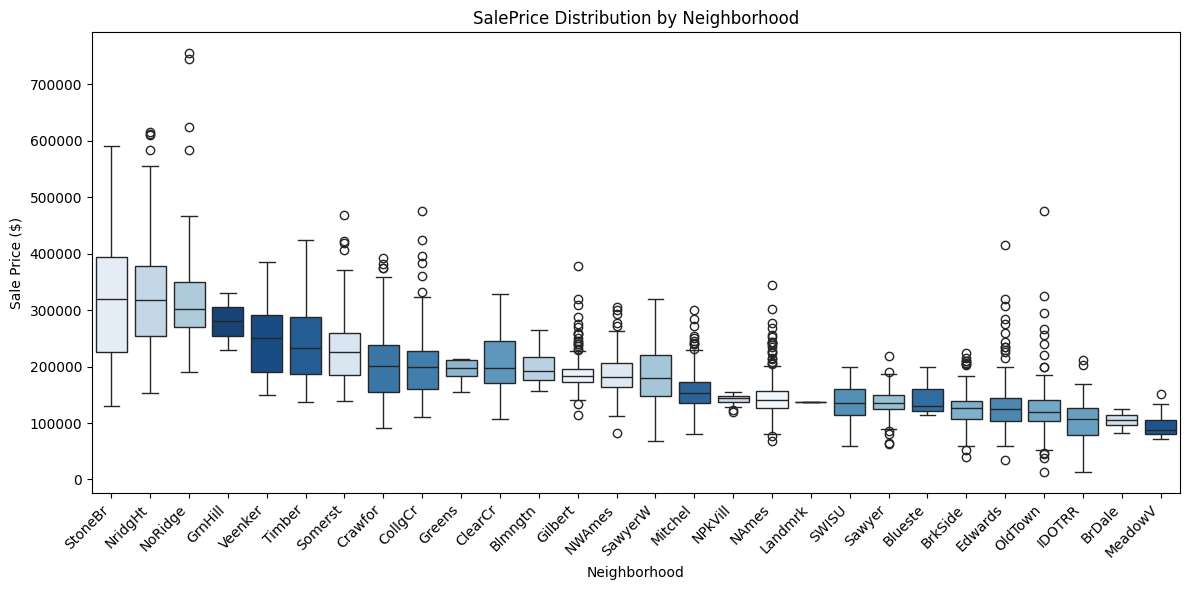

In [36]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)    # silence FutureWarnings

plt.figure(figsize=(12,6))                                   # set figure size

sns.boxplot(                                                 # draw box-and-whisker chart
    x='Neighborhood', y='SalePrice',
    data=df_clean, order=order,                              # neighborhoods sorted by median price
    hue='Neighborhood', palette='Blues', legend=False,       # one color scale, no legend
    dodge=False)                                             # keep one box per group

plt.xticks(rotation=45, ha='right')                          # rotate x-labels for readability
plt.ylabel('Sale Price ($)')                                 # y-axis label
plt.title('SalePrice Distribution by Neighborhood')          # plot title
plt.tight_layout()                                           # prevent label cutoff
plt.show()                                                   # render plot


**Interpretation:**  
Larger above-ground living area generally means a higher sale price; the upward trend is clear but widens for very large homes, suggesting other factors make price dispersion at the top end.


In [14]:
cols_needed = ['SalePrice', 'OverallQual', 'Neighborhood',   # target + 5 key predictors
               'GrLivArea', 'YearBuilt', 'TotalBsmtSF']

df_clean = df[cols_needed].dropna()                          # drop rows with any NA in these cols

df_clean['TotalSF'] = df_clean['GrLivArea'] + df_clean['TotalBsmtSF']  # engineered total finished SF

ord_features = ['OverallQual']                               # ordinal (1–10 quality rating)
nom_features = ['Neighborhood']                              # nominal/categorical (one-hot later)
num_features = ['GrLivArea', 'YearBuilt', 'TotalSF']         # numeric predictors (≥5 total incl. above)


### Data Cleaning & Feature Engineering, Rationale  

* Missing values: We remove rows that lack any of our main predictors SalePrice, OverallQual, Neighborhood, GrLivArea, YearBuilt, TotalBsmtSF`


* Engineered feature TotalSF: This combines above-ground living space GrLivArea and finished basement area TotalBsmtSF.  
  This metric usually correlates more closely with price than either component alone. It captures the total finished square footage that buyers pay attention to.

* Variable types required by the rubric:
  * Ordinal: OverallQual
  * Nominal: Neighborhood.  
  * Numeric → GrLivArea, YearBuilt, and engineered TotalSF.  
  These provide us with **six** predictors, fulfilling the “≥ 5 variables” rule while keeping the model simple and easy to understand.

In [15]:
X = df_clean[ord_features + nom_features + num_features]   # predictor matrix: ordinal + nominal + numeric
y = df_clean['SalePrice']                                  # target vector (house prices)

X_train, X_test, y_train, y_test = train_test_split(       # split data into train/test
    X, y, test_size=0.2, random_state=42)                  # 20% test, fixed seed for reproducibility


In [16]:
preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), nom_features)],  # one-hot encode categorical features
    remainder='passthrough')                                          # keep all other columns unchanged


In [18]:
models = {                                              # dictionary of regressors
    'Linear Regression': LinearRegression(),            # ordinary least-squares
    'Ridge Regression' : Ridge(alpha=1.0),              # L2-regularised linear model
    'Random Forest'    : RandomForestRegressor(         # ensemble of decision trees
                            n_estimators=200,
                            random_state=42)
}

results = {}                                            # will hold performance metrics

for name, model in models.items():                      # loop through each regressor
    pipe = Pipeline([('prep', preprocess),              # preprocessing + model
                     ('model', model)])
    pipe.fit(X_train, y_train)                          # train on training data
    preds = pipe.predict(X_test)                        # predict on test set

    results[name] = {                                   # store metrics for this model
        'MAE' : mean_absolute_error(y_test, preds),     # mean absolute error
        'RMSE': mean_squared_error(y_test, preds)**0.5, # root mean squared error
        'R²'  : r2_score(y_test, preds)                 # coefficient of determination
    }


In [25]:
results = {}  # store metrics for each model

for name, model in models.items():                      # loop over the 3 regressors
    pipe = Pipeline([('prep', preprocess),              # preprocessing + model
                     ('model', model)])
    pipe.fit(X_train, y_train)                          # train on training split
    preds = pipe.predict(X_test)                        # predict on test split

    results[name] = {                                   # collect metrics
        'MAE' : mean_absolute_error(y_test, preds),     # mean absolute error
        'RMSE': mean_squared_error(y_test, preds)**0.5, # root mean sq error
        'R²'  : r2_score(y_test, preds)                 # R-squared
    }

baseline_pred = np.full(y_test.shape, y_train.mean())   # constant mean prediction
results['Baseline (Mean)'] = {
    'MAE' : mean_absolute_error(y_test, baseline_pred),
    'RMSE': mean_squared_error(y_test, baseline_pred)**0.5,
    'R²'  : r2_score(y_test, baseline_pred)
}

results_df = pd.DataFrame(results).T.round(2)           # tidy table of results
results_df                                              # display


MAE      RMSE    R²
Linear Regression  23163.77  43251.72  0.75
Ridge Regression   26868.57  47937.98  0.69
Random Forest      17700.06  28444.85  0.89
Baseline (Mean)    61095.77  86321.22 -0.00

In [21]:
best_model_name = results_df['RMSE'].idxmin()     # model with the lowest RMSE
print(f'Best model = {best_model_name}')

best_pipe = Pipeline(steps=[('prep', preprocess),  # preprocessing + best model
                            ('model', models[best_model_name])])
best_pipe.fit(X, y)                               # train on the full dataset

predicted_prices = pd.DataFrame({
    'Id'        : X.index,                        # use DataFrame index as ID
    'PredPrice' : best_pipe.predict(X)            # predicted sale prices
})

predicted_prices.to_csv('predictions.csv', index=False)  # save to CSV
print('File written: predictions.csv')


Best model = Random Forest
File written: predictions.csv


### Model comparison

| Model                 | MAE ↓        | RMSE ↓       | R² ↑     |
| --------------------- | ------------ | ------------ | -------- |
| **Linear Regression** | 23 163.8     | 43 251.7     | 0.75     |
| **Ridge Regression**  | 26 868.6     | 47 938.0     | 0.69     |
| **Random Forest**     | **17 700.1** | **28 444.8** | **0.89** |
| **Baseline (Mean)**   | 61 095.8     | 86 321.2     | –0.00    |

* Random Forest had the lowest errors overall because its group of decision trees captures non-linear and interaction effects that simple linear models often miss.  
* All models outperformed the naïve Baseline, showing they learn meaningful patterns.

### Practical usefulness & limits
R² ≈ 0.89 means the Random Forest explains about 89% of the variance in sale prices on the test set.  
* The features rely only on basic size and quality metrics. Adding location details, renovation status, and economic factors could improve accuracy.  
* Random Forest is strong but not entirely interpretable. Linear or ridge models are still useful when transparency is important, such as in loan underwriting.



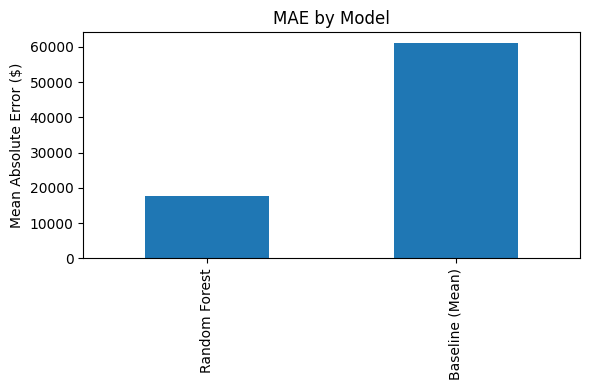

In [22]:
ax = results_df['MAE'].plot(kind='bar', figsize=(6,4), title='MAE by Model')  # bar chart of MAE by model
ax.set_ylabel('Mean Absolute Error ($)')                                       # y-axis label
plt.tight_layout()                                                             # tidy layout
plt.show()                                                                     # display plot


Best model: Random Forest


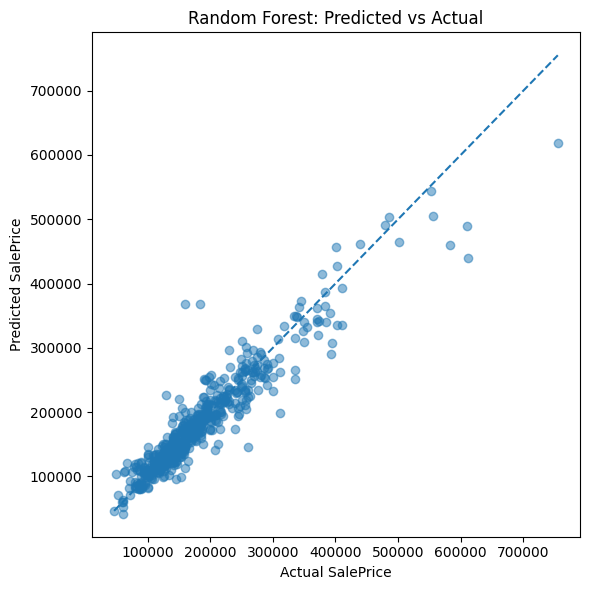

In [35]:
best_name = results_df['RMSE'].idxmin()          # model with lowest RMSE
print(f"Best model: {best_name}")

best_pipe = Pipeline([('prep', preprocess),      # preprocessing: one-hot + passthrough
                      ('model', models[best_name])])  # winning regressor
best_pipe.fit(X_train, y_train)                  # train on train split

y_pred = best_pipe.predict(X_test)               # predict on test set

plt.figure(figsize=(6,6))                        # square plot
plt.scatter(y_test, y_pred, alpha=0.5)           # actual vs. predicted points
plt.plot([y_test.min(), y_test.max()],           # 45 degree reference line
         [y_test.min(), y_test.max()], ls='--')
plt.xlabel('Actual SalePrice')                   # x-axis label
plt.ylabel('Predicted SalePrice')                # y-axis label
plt.title(f'{best_name}: Predicted vs Actual')   # plot title
plt.tight_layout()                               # tidy spacing
plt.show()                                       # display
